In [1]:
from kSZ_forecast_general_func import *
from kSZ_forecast_HOD import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
Grid = 512
Snapshot = 1631
Redshift = snap_info.get_redshift(Snapshot)[0]
MAS = "NGP"

In [3]:
#particle den, vel, mom, kSZ
cnorm=ne0*sigma_t*Mpc2m*Boxlen*1.0/Grid*(1+Redshift)**2/h  # proj mom: km/h -> dkSZ/CMB
Thelen = Boxlen/h/cosmo.comoving_distance(z=Redshift).value

the_los=(45)*np.pi/180
n_rsd=np.array([np.cos(the_los),np.sin(the_los),0])


Den_dir= "/home/chenzy/data/denmap/den"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
Mom_dir = "/home/chenzy/data/mommap/mom"+MAS+"_"+str(Grid)+"_"+str(Snapshot)+"_0"
momp=snap_info.get_vel_norm(Snapshot)*np.fromfile(Mom_dir, dtype=np.float32, count=3*Grid**3, sep="").reshape(Grid,Grid,Grid,3)
denp=np.fromfile(Den_dir, dtype=np.float32, count=Grid**3, sep="").reshape((Grid,)*3)
velp = momden2vel(denp, momp)
momp = (denp-1).reshape(Grid, Grid, Grid,1)*velp
momp_proj=proj1(momp,the_los)*cnorm

In [4]:
print("Read halos")
halox,halov, mh =ReadHalos_np(zstep=Snapshot)
halo_mass = mh*pm

haloxx_rsd=add_RSD(halox*Boxlen,halov*(1+snap_info.get_redshift(Snapshot)), n_rsd, cosmo.H(snap_info.get_redshift(Snapshot)).value)%Boxlen   #Mpc/h

Read halos


In [6]:
print("Generate galaxy")
n_gal = 4*10**-4
HOD_model = "HSC_NB912"
HOD_random_seed = 100
if HOD_model == "DESI":
    richnezss = np.zeros(len(halo_mass), dtype = np.int32)
    for i in range(4):
        HOD_model = "DESI_L"+str(i)
        d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model+"_seed"+str(HOD_random_seed)+".npz")
        N_cen = d["N_cen"]
        N_sat = d["N_sat"]
        richness = N_cen + N_sat
else:
    d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model+"_seed"+str(HOD_random_seed)+".npz")
    N_cen = d["N_cen"]
    N_sat = d["N_sat"]
    richness = N_cen + N_sat
N_gal = np.sum(richness)
print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)
galaxy_pos = np.zeros((N_gal, 3))
print(richness)
for i in range(3):
    galaxy_pos[:,i]=np.repeat(haloxx_rsd[:,i], richness)

#rand to make density (for n_gal)
N_gal_need = np.int32(n_gal*Boxlen**3)
a = np.arange(N_gal, dtype=np.int32)
np.random.shuffle(a)
galaxy_pos = galaxy_pos[list(a[:N_gal_need]),:]
N_gal = len(galaxy_pos[:,0])
print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)

Generate galaxy
Number of galaxies 5574400    n= 0.003225925925925926
[150 136 103 ...   0   0   0]
Number of galaxies 691200    n= 0.0004


In [7]:
#Generate halo
lgM_min2 = 12.18
lgM_max2 = 20

label2 = np.where((halo_mass<10**lgM_max2)&(halo_mass>10**lgM_min2))[0]
n_halo2 = len(label2)/Boxlen**3
print("Halo sample to stack: n = "+str(n_halo2*10**4)+"$10^{-4}$ lgM_min "+str(lgM_min2))

Halo sample to stack: n = 9.968038194444444$10^{-4}$ lgM_min 12.18


In [5]:
def add_photo_z_simple_proj1(pos, sigma_D, the_los):
    Delta = np.random.normal(loc=0.0, scale=sigma_D, size=len(pos[:,0]))
    print(Delta, np.cos(the_los))
    pos_new = np.zeros(pos.shape)
    pos_new[:,0]=pos[:,0]+Delta*np.cos(the_los)
    pos_new[:,1]=pos[:,1]+Delta*np.sin(the_los)
    pos_new[:,2]=pos[:,2]
    return pos_new
sigma_D = c_speed*0.01*(1+Redshift)/cosmo.H(2).value*h #Mpc/h comoving
sigma_D

32.09224050386616

In [9]:
galaxy_pos_photo_z = add_photo_z_simple_proj1(pos=galaxy_pos[:,:], sigma_D=sigma_D, the_los=the_los)
halo_pos_photo_z = add_photo_z_simple_proj1(pos=haloxx_rsd[label2,:], sigma_D=sigma_D, the_los=the_los)

[-24.5943342   -2.09810818  47.73560349 ... -31.88143439  55.71546128
 -54.39672271] 0.7071067811865476
[ -2.1735728   22.65465325  27.07043791 ... -48.05394986 -14.45735444
 -28.55429878] 0.7071067811865476


In [9]:
galaxy_pos_photo_z, galaxy_pos, sigma_D

(array([[ 999.25242049,  895.08264643,  918.42842102],
        [1069.90415475,  221.24120614,  900.56362152],
        [ 804.49744621,  203.25277605,  686.13502979],
        ...,
        [  38.19561591, 1172.48575529,  437.12360859],
        [  82.84568426,  708.65749356, 1181.28046989],
        [ 174.41693049, 1152.48841744,  331.32863045]]),
 array([[1008.72190372,  904.55212966,  918.42842102],
        [1101.66367874,  253.00073013,  900.56362152],
        [ 808.53043215,  207.285762  ,  686.13502979],
        ...,
        [  42.81188242, 1177.10202179,  437.12360859],
        [  92.58242674,  718.39423604, 1181.28046989],
        [ 205.87470537, 1183.94619232,  331.32863045]]),
 32.09224050386616)

In [6]:
thetap = vel2theta(velp, Boxlen)
def rec_vel(pos):
    # for den_method
    den_tracer=den_NGP(pos,Grid)

    W,kx,ky,kz=wiener_filter_theta_esti(den_tracer,thetap, Boxlen)
    #del thetap
    thetag_rsd_rec=wiener_filter_den2theta(den_tracer,W,kx,ky,kz, Boxlen)
    #del W,kx,ky,kz
    velg_rsd_rec=theta2vel(thetag_rsd_rec, Boxlen)
    return velg_rsd_rec

In [11]:
vel_rec_gal_spec = rec_vel(galaxy_pos)

/home/chenzy/code/kSZ_forecast/kSZ_forecast_general_func.py:222: RuntimeWarning: invalid value encountered in true_divide
  W=cor_the_delta_f[0]/ps_delta[0]


In [12]:
vel_rec_gal_photo = rec_vel(galaxy_pos_photo_z)
vel_rec_halo_photo = rec_vel(halo_pos_photo_z)

In [7]:
def cal_r_vel(vel_rec, halox, halov, the_los, grid):
    '''
    vel_rec: (grid, grid, grid, 3), simu coor
    halox: (N, 3), simu coor
    halov: (N, 3), simu coor, only for rv
    the_los:
    '''
    Nh = len(halov[:,0])
    
    #vec_rec_los
    vx = interpn((np.arange(grid),np.arange(grid),np.arange(grid)), vel_rec[:,:,:,0], halox*grid, bounds_error=0, fill_value=0)
    vy = interpn((np.arange(grid),np.arange(grid),np.arange(grid)), vel_rec[:,:,:,1], halox*grid, bounds_error=0, fill_value=0)
    halov_rec_los = np.cos(the_los)*vx+np.sin(the_los)*vy

    halov_los = np.cos(the_los)*halov[:,0]+np.sin(the_los)*halov[:,1]
    r_true_rec = np.mean(halov_rec_los*halov_los)/np.std(halov_rec_los)/np.std(halov_los)
    print(np.std(halov_los), np.std(halov_rec_los))
    print(r_true_rec)
    return r_true_rec

# Photo-z, spec-z

In [8]:
#Generate halo
lgM_min2 = 12.18
lgM_max2 = 20

label2 = np.where((halo_mass<10**lgM_max2)&(halo_mass>10**lgM_min2))[0]
n_halo2 = len(label2)/Boxlen**3
print("Halo sample to stack: n = "+str(n_halo2*10**4)+"$10^{-4}$ lgM_min "+str(lgM_min2))

Halo sample to stack: n = 9.968038194444444$10^{-4}$ lgM_min 12.18


In [27]:
print("Generate galaxy")
n_gal = 3*10**-3
HOD_model = "HSC_NB912"
HOD_random_seed = 100
if HOD_model == "DESI":
    richnezss = np.zeros(len(halo_mass), dtype = np.int32)
    for i in range(4):
        HOD_model = "DESI_L"+str(i)
        d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model+"_seed"+str(HOD_random_seed)+".npz")
        N_cen = d["N_cen"]
        N_sat = d["N_sat"]
        richness = N_cen + N_sat
else:
    d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model+"_seed"+str(HOD_random_seed)+".npz")
    N_cen = d["N_cen"]
    N_sat = d["N_sat"]
    richness = N_cen + N_sat
N_gal = np.sum(richness)
print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)
galaxy_pos = np.zeros((N_gal, 3))
print(richness)
for i in range(3):
    galaxy_pos[:,i]=np.repeat(haloxx_rsd[:,i], richness)

#rand to make density (for n_gal)
N_gal_need = np.int32(n_gal*Boxlen**3)
a = np.arange(N_gal, dtype=np.int32)
np.random.shuffle(a)
galaxy_pos = galaxy_pos[list(a[:N_gal_need]),:]
N_gal = len(galaxy_pos[:,0])
print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)

Generate galaxy
Number of galaxies 5574400    n= 0.003225925925925926
[150 136 103 ...   0   0   0]
Number of galaxies 5184000    n= 0.003


In [36]:
galaxy_pos_photo_z.shape[0]/Boxlen**3

0.003

In [47]:
sigma_zs = 10**np.linspace(-4, -2, 10)
r1 = np.zeros(10)

for i in range(len(sigma_zs)):
    sigma_z = sigma_zs[i]
    sigma_z = 0.005
    sigma_D = c_speed*sigma_z*(1+Redshift)/cosmo.H(2).value*h #Mpc/h comoving
    print(sigma_D, halox.shape[0]/Boxlen**3)
    
    halo_pos_photo_z = add_photo_z_simple_proj1(pos=haloxx_rsd, sigma_D=sigma_D, the_los=the_los)
    vel_rec_halo_photo_z = rec_vel(halo_pos_photo_z)
    
    r1[i] = cal_r_vel(vel_rec = vel_rec_halo_photo_z, halox = haloxx_rsd[label2,:]/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)
    
    break

16.04612025193308 0.05686915625
[-22.97410377 -39.2944531  -18.93039554 ... -16.75488183 -19.63389463
   7.47689239] 0.7071067811865476
248.32259669647433 0.001187246849551657
0.0629835454146485


In [28]:
sigma_zs = 10**np.linspace(-4, -2, 10)
r1 = np.zeros(10)

for i in range(len(sigma_zs)):
    sigma_z = sigma_zs[i]
    sigma_D = c_speed*sigma_z*(1+Redshift)/cosmo.H(2).value*h #Mpc/h comoving
    print(sigma_D)
    
    galaxy_pos_photo_z = add_photo_z_simple_proj1(pos=galaxy_pos[:,:], sigma_D=sigma_D, the_los=the_los)
    vel_rec_gal_photo = rec_vel(galaxy_pos_photo_z)
    
    r1[i] = cal_r_vel(vel_rec = vel_rec_gal_photo, halox = haloxx_rsd[label2,:]/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)
    
    

0.3209224050386616
[ 0.7965223   0.0993799  -0.06133326 ...  0.5026917  -0.1995923
  0.41497801] 0.7071067811865476
248.32259669647433 0.0008390348522315436
0.6764753001759214
0.5353308362445264
[ 0.02112303  0.6768198  -0.04542655 ...  0.00974038 -0.22110882
 -0.40706228] 0.7071067811865476
248.32259669647433 0.0008371465172077054
0.6706400476873845
0.8929856555192514
[ 0.81180394  1.56177642 -0.27273357 ...  0.70963619 -0.53026346
  0.65604757] 0.7071067811865476
248.32259669647433 0.0008348487266571204
0.6580020502456971
1.4895898516836086
[-0.62513712  1.09612927  0.12334807 ... -0.84174906 -0.50865333
 -0.25237542] 0.7071067811865476
248.32259669647433 0.0008248603364540239
0.6375158595776347
2.4847856318011843
[ 0.15590504  2.5466421  -3.6337006  ... -3.06346997  1.52979543
 -1.35802689] 0.7071067811865476
248.32259669647433 0.000786951514025329
0.6013275735960616
4.144872247234543
[-3.82879139 -0.38926014  0.18887863 ...  4.06659988 -8.14383751
  1.47774343] 0.7071067811865476
2

In [29]:
sigma_zs = 10**np.linspace(-4, -2, 10)
r2 = np.zeros(10)

vel_rec_gal_spec = rec_vel(galaxy_pos)
for i in range(len(sigma_zs)):
    sigma_z = sigma_zs[i]
    sigma_D = c_speed*sigma_z*(1+Redshift)/cosmo.H(2).value*h #Mpc/h comoving
    print(sigma_D)
    
    halo_pos_photo_z = add_photo_z_simple_proj1(pos=haloxx_rsd[label2,:], sigma_D=sigma_D, the_los=the_los)
    r2[i] = cal_r_vel(vel_rec = vel_rec_gal_spec, halox = halo_pos_photo_z/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)
    
    

0.3209224050386616
[-0.31280199 -0.04364115 -0.04448762 ... -0.16750617  0.33697211
  0.37992469] 0.7071067811865476
248.32259669647433 0.0008406992383652997
0.680314668129125
0.5353308362445264
[ 0.2214236   0.00274872 -0.30627469 ... -0.1360372  -0.66176045
 -0.00344144] 0.7071067811865476
248.32259669647433 0.0008419319872512857
0.6792920447323799
0.8929856555192514
[ 0.9265249  -0.34400509  0.43450062 ...  0.45056691 -0.34124618
  0.62861221] 0.7071067811865476
248.32259669647433 0.0008454498006385441
0.6761054921336285
1.4895898516836086
[-0.21967601  2.14007332 -0.19091861 ... -2.45806193 -0.33306742
  0.4091143 ] 0.7071067811865476
248.32259669647433 0.0008538811185773525
0.668813837001415
2.4847856318011843
[-1.64279907 -0.06649037  3.60687179 ...  2.70824799  1.76900041
 -2.47788751] 0.7071067811865476
248.32259669647433 0.0008711180014124322
0.6533893593763901
4.144872247234543
[ 1.25928254 -0.52084787  1.3497421  ...  5.48150778  1.8844089
 -4.35486266] 0.7071067811865476
24

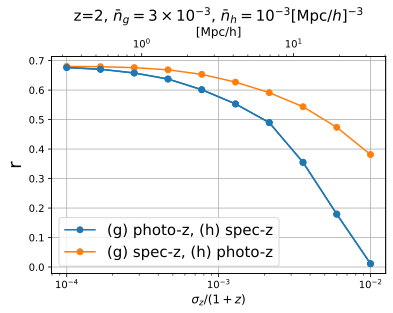

In [46]:
sigma_Ds = c_speed*sigma_zs*(1+Redshift)/cosmo.H(2).value*h #Mpc/h comoving
fig, ax = plt.subplots()
ax2 = ax.twiny()
ax.plot(sigma_zs, r1,"-o", label = "(g) photo-z, (h) spec-z")
ax2.plot(sigma_Ds, r1,"-o", label = "(g) photo-z, (h) spec-z")
ax.plot(sigma_zs, r2,"-o", label = "(g) spec-z, (h) photo-z")
ax.legend(fontsize=15)
ax.set_xscale("log")
ax2.set_xscale("log")
ax2.set_xlabel("[Mpc/h]", fontsize=12)
ax.set_xlabel(r"$\sigma_z/(1+z)$", fontsize=12)
ax.set_ylabel("r", fontsize=18)
ax.set_title(r"z=2, $\bar n_g = 3\times10^{-3}$, $\bar n_h = 10^{-3} [{\rm Mpc}/h]^{-3}$", fontsize=15)
ax.grid()

# Null small scale mode

In [18]:
def wiener_filter_den2theta_small_null(den,W,kx,ky,kz, boxlen):
    grid=den.shape[0]
    kmod,kxx,kyy,kzz=fa.karray(grid,True)
    kx=(kx[1:]+kx[:-1])/2
    ky=(ky[1:]+ky[:-1])/2
    kz=(kz[1:]+kz[:-1])/2
    kx=kx[6:];ky=ky[6:];kz=kz[6:]

    kx[0]=0;kx[-1]=6
    ky[0]=0;ky[-1]=6
    kz[0]=0;kz[-1]=6

    W_new=np.zeros((24,24,24))
    W_new[0,0,0]=(np.mean(W[0,0,7:])+np.mean(W[0,7:,0])+np.mean(W[7:,0,0]))/3
    W_new[0,0,1:]=W[0,0,7:]
    W_new[0,1:,0]=W[0,7:,0]
    W_new[1:,0,0]=W[7:,0,0]
    W_new[0,1:,1:]=W[0,7:,7:]
    W_new[1:,0,1:]=W[7:,0,7:]
    W_new[1:,1:,0]=W[0,7:,7:]
    W_new[1:,1:,1:]=W[7:,7:,7:]
    W=W_new

    kcoor=np.zeros((len(kxx.flatten()),3))
    kcoor[:,0]=np.abs(kxx).flatten()*2*np.pi/boxlen
    kcoor[:,1]=np.abs(kyy).flatten()*2*np.pi/boxlen
    kcoor[:,2]=np.abs(kzz).flatten()*2*np.pi/boxlen
    wintp=interpn(np.array([kx,ky,kz]),W,kcoor)
    wintp=wintp.reshape(grid,grid,grid//2+1)
    
    label=np.where(kxx*2*np.pi/boxlen>0.3)
    print(label)
    wintp[label]=0

    thetak=np.fft.rfftn(den)*wintp
    return np.fft.irfftn(thetak)

def rec_vel_null_small_scale_mode(pos):
    # for den_method
    den_tracer=den_NGP(pos,Grid)

    W,kx,ky,kz=wiener_filter_theta_esti(den_tracer,thetap, Boxlen)
    #del thetap
    thetag_rsd_rec=wiener_filter_den2theta_small_null(den_tracer,W,kx,ky,kz, Boxlen)
    #del W,kx,ky,kz
    velg_rsd_rec=theta2vel(thetag_rsd_rec, Boxlen)
    return velg_rsd_rec
sigma_D = c_speed*0.01*(1+Redshift)/cosmo.H(2).value*h #Mpc/h comoving
print(sigma_D)
halo_pos_photo_z = add_photo_z_simple_proj1(pos=haloxx_rsd[label2,:], sigma_D=sigma_D, the_los=the_los)
vel_rec_halo_photo = rec_vel(halo_pos_photo_z)
vel_rec_halo_photo = rec_vel_null_small_scale_mode(halo_pos_photo_z)

32.09224050386616
[-32.02682356  12.26132558 -53.65410454 ...  52.26429265  -3.3186782
  66.16339392] 0.7071067811865476
(array([ 58,  58,  58, ..., 255, 255, 255]), array([  0,   0,   0, ..., 511, 511, 511]), array([  0,   1,   2, ..., 254, 255, 256]))


In [19]:
cal_r_vel(vel_rec = vel_rec_halo_photo, halox = halo_pos_photo_z/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)

248.32259669647433 0.0006430272879522815
0.02254030571497985


0.02254030571497985

In [17]:
print(sigma_D)

3.209224050386616


In [21]:
cal_r_vel(vel_rec = vel_rec_gal_spec, halox = halox[label2,:], halov=halov[label2,:], the_los=the_los, grid=Grid)

248.32259669647433 0.0008554060165092733
0.8235622858363177


0.8235622858363177

In [22]:
cal_r_vel(vel_rec = vel_rec_gal_spec, halox = haloxx_rsd[label2,:]/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)

248.32259669647433 0.0007406064487162484
0.6857088913309737


0.6857088913309737

In [23]:
cal_r_vel(vel_rec = vel_rec_gal_photo, halox = haloxx_rsd[label2,:]/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)

248.32259669647433 0.000538098336050073
0.01994265383674912


0.01994265383674912

In [24]:
cal_r_vel(vel_rec = vel_rec_gal_spec, halox = halo_pos_photo_z/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)

248.32259669647433 0.0007547823847063399
0.3824270595030352


0.3824270595030352

In [25]:
cal_r_vel(vel_rec = vel_rec_gal_photo, halox = halo_pos_photo_z/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)

248.32259669647433 0.0005337497972518152
0.007382054510492329


0.007382054510492329

In [27]:
cal_r_vel(vel_rec = vel_rec_gal_photo2, halox = halo_pos_photo_z/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)

248.32259669647433 0.0029083403540921325
-0.0387638284874603


-0.0387638284874603

# $\sigma_z$ - r

In [13]:
sigma_zs = 10**np.linspace(-4, -2, 5)
r1 = np.zeros(5)
r2 = np.zeros(5)
for i in range(len(sigma_zs)):
    sigma_z = sigma_zs[i]
    sigma_D = c_speed*sigma_z*(1+Redshift)/cosmo.H(2).value*h #Mpc/h comoving
    print(sigma_D)
    halo_pos_photo_z = add_photo_z_simple_proj1(pos=haloxx_rsd[label2,:], sigma_D=sigma_D, the_los=the_los)
    r2[i] = cal_r_vel(vel_rec = vel_rec_gal_spec, halox = halo_pos_photo_z/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)
    #continue

    vel_rec_halo_photo = rec_vel(halo_pos_photo_z)
    r1[i] = cal_r_vel(vel_rec = vel_rec_halo_photo, halox = halo_pos_photo_z/Boxlen, halov=halov[label2,:], the_los=the_los, grid=Grid)
    print()
    

0.3209224050386616
[-0.1018963  -0.04017037 -0.09868133 ... -0.79130491 -0.36710808
 -0.56616984] 0.7071067811865476
248.32259669647433 0.0007556446925103984
0.6897819594178497
248.32259669647433 0.0008059151442372555
0.6931263571614734

1.0148457521012677
[-0.41335964 -1.38977145  0.47651428 ...  0.92467231  1.10395131
  0.77907951] 0.7071067811865476
248.32259669647433 0.0007584504043687786
0.6864075744526938
248.32259669647433 0.000808905221654195
0.6670685841568977

3.209224050386616
[ 1.61728114 -5.1507933   1.72489028 ... -4.44159034  0.16460828
 -1.77517871] 0.7071067811865476
248.32259669647433 0.0007779704510932575
0.6618040680058074


KeyboardInterrupt: 

In [ ]:
sigma_zs = 10**np.linspace(-4, -2, 5)
r1 = np.array([0.68837, 0.6849, 0.66, 0.576, 0.389])
r2 = np.array([0.6937, 0.666, 0.585, 0.4117, 0.006])

plt.plot(sigma_zs, r1, label = "spac-z, photo-z")
plt.plot(sigma_zs, r2, label = "photo-z, photo-z")
plt.

# r(k)

In [13]:
r1, k = fa.CalRvector(velp, vel_rec_gal_spec, Grid)
r2, k = fa.CalRvector(velp, vel_rec_gal_photo, Grid)
r3, k = fa.CalRvector(velp, vel_rec_halo_photo, Grid)

In [31]:
r4, k = fa.CalRvector(velp, vel_rec_gal_photo2, Grid)

Text(0, 0.5, 'r(k)')

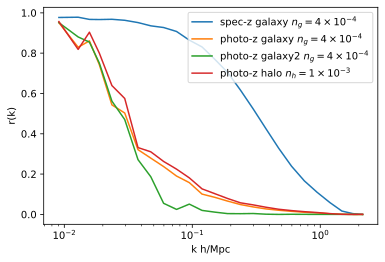

In [32]:
fig, ax = plt.subplots()
ax.plot(k*2*np.pi/Boxlen,r1, label = r"spec-z galaxy $n_g=4\times 10^{-4}$")
ax.plot(k*2*np.pi/Boxlen,r2, label = r"photo-z galaxy $n_g=4\times 10^{-4}$")
#ax.plot(k*2*np.pi/Boxlen,r4, label = r"photo-z galaxy2 $n_g=4\times 10^{-4}$")
ax.plot(k*2*np.pi/Boxlen,r3, label = r"photo-z halo $n_h=1\times 10^{-3}$")
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend()
ax.set_xlabel("k h/Mpc")
ax.set_ylabel("r(k)")

# $r$ as a function of galaxy number density (spec-spec)

In [57]:
n_gals = np.array([0.5, 1, 2, 3,  5, 7])*10**-4
r = np.zeros(len(n_gals))
for j in range(len(r)):
    print("Generate galaxy")
    n_gal = n_gals[j]
    HOD_model = "HSC_NB912"
    HOD_random_seed = 100
    if HOD_model == "DESI":
        richnezss = np.zeros(len(halo_mass), dtype = np.int32)
        for i in range(4):
            HOD_model = "DESI_L"+str(i)
            d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model+"_seed"+str(HOD_random_seed)+".npz")
            N_cen = d["N_cen"]
            N_sat = d["N_sat"]
            richness = N_cen + N_sat
    else:
        d = np.load("./halo_Temporary_storage/halos_"+str(Snapshot)+"_"+HOD_model+"_seed"+str(HOD_random_seed)+".npz")
        N_cen = d["N_cen"]
        N_sat = d["N_sat"]
        richness = N_cen + N_sat
    N_gal = np.sum(richness)
    print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)
    galaxy_pos = np.zeros((N_gal, 3))
    galaxy_vel = np.zeros((N_gal, 3))
    for i in range(3):
        galaxy_pos[:,i]=np.repeat(haloxx_rsd[:,i], richness)
        galaxy_vel[:,i]=np.repeat(halov[:,i], richness)

    #rand to make density (for n_gal)
    N_gal_need = np.int32(n_gal*Boxlen**3)
    a = np.arange(N_gal, dtype=np.int32)
    np.random.shuffle(a)
    galaxy_pos = galaxy_pos[list(a[:N_gal_need]),:]
    galaxy_vel = galaxy_vel[list(a[:N_gal_need]),:]
    N_gal = len(galaxy_pos[:,0])
    print("Number of galaxies", N_gal,"   n=",N_gal/Boxlen**3)

    vel_rec_gal_spec = rec_vel(galaxy_pos)

    r[j] = cal_r_vel(vel_rec = vel_rec_gal_spec, halox = galaxy_pos/Boxlen, halov=galaxy_vel, the_los=the_los, grid=Grid)


Generate galaxy
Number of galaxies 5574400    n= 0.003225925925925926
Number of galaxies 86400    n= 5e-05
248.01684120517066 0.0005081010144732959
0.5774527470605287
Generate galaxy
Number of galaxies 5574400    n= 0.003225925925925926
Number of galaxies 172800    n= 0.0001
248.14490866972403 0.0006240814720877837
0.6466596224620631
Generate galaxy
Number of galaxies 5574400    n= 0.003225925925925926
Number of galaxies 345600    n= 0.0002
247.6231456161355 0.0006870151631585569
0.673569729952142
Generate galaxy
Number of galaxies 5574400    n= 0.003225925925925926
Number of galaxies 518400    n= 0.0003
248.02403083229694 0.0007339490127195377
0.6861918756302071
Generate galaxy
Number of galaxies 5574400    n= 0.003225925925925926
Number of galaxies 864000    n= 0.0005


KeyboardInterrupt: 

Text(0.5, 1.0, 'spec-spec')

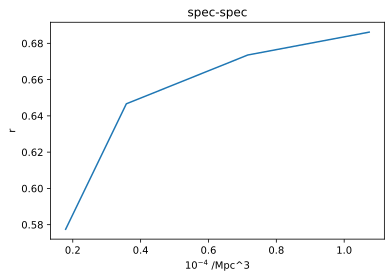

In [72]:
fig, ax = plt.subplots()
ax.plot(n_gals[:4]*h**3*10**4, r[:4])
ax.set_xlabel("$10^{-4}$ /Mpc^3")
ax.set_ylabel("r")
ax.set_title("spec-spec")

In [65]:
r[0] = 0.5774527470605287
r[1] = 0.6466596224620631
r[2] = 0.673569729952142
r[3] = 0.68619188